## Loading the dataset through kaggle API

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vangap/indian-supreme-court-judgments

Dataset URL: https://www.kaggle.com/datasets/vangap/indian-supreme-court-judgments
License(s): CC-BY-NC-SA-4.0
100% 4.75G/4.77G [00:23<00:00, 264MB/s]
100% 4.77G/4.77G [00:23<00:00, 220MB/s]


In [ ]:
!unzip indian-supreme-court-judgments.zip

## Contains 48K PDFS

In [ ]:
import os

folder_path = "/content/pdfs"  # Replace with your folder path
num_pdfs = len([f for f in os.listdir(folder_path) if f.endswith(".pdf")])

print(f"Number of PDFs in the folder: {num_pdfs}")

Number of PDFs in the folder: 48294


## Install PyMuPDF (fitz) – an alternative high-performance library for reading and extracting text, images, and metadata from PDFs

In [ ]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 17.4 MB/s eta 0:00:00


## Extract Data From Pdfs

In [ ]:
import os
import fitz  # PyMuPDF
import json
import re

# Folder containing all case PDFs
PDF_FOLDER = "/content/dataset/pdfs"  # Change this to your actual folder
OUTPUT_JSON = "CASE_DATA_NEW.json"

def extract_text_from_pdf(pdf_path):
    """Extract text from a single PDF."""
    # Check if the file is empty before opening it
    if os.path.getsize(pdf_path) == 0:
        print(f"Warning: Skipping empty PDF: {pdf_path}")
        return ""  # Return an empty string for empty PDFs

    doc = fitz.open(pdf_path)
    text = "\n".join([page.get_text("text") for page in doc])
    return text

def extract_judges(text):
    bench_blocks = re.findall(r"BENCH:\s*((?:.|\n)*?)(?=\n\S|$)", text)  # Capture everything after BENCH until next section
    judges_list = []
    for block in bench_blocks:
        lines = block.strip().splitlines()
        for line in lines:
            line = line.strip()
            if line:
                judges_list.append(line)
    return ", ".join(judges_list) if judges_list else "Unknown"


def extract_case_details(text):
    """Extracts structured case details using regex based on the new structure."""
    case_data = {}

    # Extract Case Title from PETITIONER and RESPONDENT
    petitioner = re.search(r"PETITIONER:\s*(.+)", text, re.IGNORECASE)
    respondent = re.search(r"RESPONDENT:\s*(.+)", text, re.IGNORECASE)
    case_data["case_title"] = f"{petitioner.group(1).strip()} vs. {respondent.group(1).strip()}" if petitioner and respondent else "Unknown"

    # Extract Date of Judgment in the format: DATE OF JUDGMENT14/11/1995
    date_match = re.search(r"DATE OF JUDGMENT[:\s]*([0-9]{2}/[0-9]{2}/[0-9]{4})", text)
    case_data["date_of_judgment"] = date_match.group(1) if date_match else "Unknown"


    # Extract Judges from BENCH: Section
    case_data["judges"] = extract_judges(text)


    # Extract Legal Sections (Keeping this unchanged)
    case_data["legal_sections"] = re.findall(r"(Section\s\d+|IPC\s\d+)", text)
    case_data["legal_sections"] = list(set(case_data["legal_sections"])) if case_data["legal_sections"] else []

    # Extract Case Summary (Taking a portion of the text)
    case_data["case_summary"] = " ".join(text.split("\n")[10:50])


    return case_data

In [ ]:
def process_all_pdfs():
    """Processes all PDFs in a folder and extracts case details."""
    case_laws = []

    for filename in os.listdir(PDF_FOLDER):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(PDF_FOLDER, filename)
            print(f"Processing: {filename}")

            text = extract_text_from_pdf(pdf_path)
            # Skip processing if the PDF is empty
            if not text:
                continue

            case_details = extract_case_details(text)
            case_details["file_name"] = filename

            case_laws.append(case_details)

    # Save extracted data to JSON
    with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
        json.dump(case_laws, f, indent=4)

    print(f"✅ Extraction complete! Data saved in {OUTPUT_JSON}")

if __name__ == "__main__":
    process_all_pdfs()

In [ ]:
# Install dependencies
!pip install gradio faiss-cpu -q

import os
import pickle
import json
import numpy as np
import pandas as pd
import gradio as gr
from tqdm import tqdm
from urllib.parse import quote
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import faiss

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 38.2 MB/s eta 0:00:00


In [ ]:
# Load models once
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", device=-1)

# Case categories
case_categories = {
    "Civil Cases": ["Land disputes", "Property disputes (ownership, possession, partition)", "Contract disputes", "Money recovery", "Family property division"],
    "Criminal Cases": ["Theft", "Murder", "Rape", "Attempt to murder", "Kidnapping / Abduction", "Assault / Grievous hurt", "Cybercrime", "Domestic violence", "Narcotics / Drug offences", "Corruption / Bribery"],
    "Family Law Cases": ["Divorce", "Child custody", "Alimony / Maintenance", "Domestic cruelty under 498A"],
    "Constitutional Cases": ["Fundamental rights violations", "Writ petitions (Habeas Corpus, Mandamus, Certiorari, Prohibition, Quo Warranto)", "Constitutional interpretation"],
    "Service / Employment Cases": ["Wrongful termination", "Promotions / Transfers", "Pension disputes", "Recruitment irregularities"],
    "Tax / Revenue Cases": ["Income tax appeals", "GST-related cases", "Land revenue disputes"],
    "Consumer Disputes": ["Deficiency in service", "Defective products", "Insurance disputes", "Banking / loan complaints"],
    "Property & Tenancy Cases": ["Eviction", "Rent control", "Illegal possession"],
    "Environmental Cases": ["Pollution control", "Forest / Wildlife protection", "Public interest litigations (PILs)"],
    "Corporate & Commercial Cases": ["Company law violations", "Insolvency & Bankruptcy (IBC)", "Arbitration & commercial disputes"]
}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
# Load JSON data
def load_case_data(json_file):
    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)
        for record in data:
            if isinstance(record.get("legal_sections"), list):
                record["legal_sections"] = tuple(record["legal_sections"])
        return pd.DataFrame(data)

# Encode summaries
def encode_cases(df, vector_file="/content/vectors.pkl"):
    if os.path.exists(vector_file):
        with open(vector_file, "rb") as f:
            vectors = pickle.load(f)
    else:
        vectors_list = []
        batch_size = 512
        for i in tqdm(range(0, len(df), batch_size), desc="Encoding"):
            batch = df["case_summary"].iloc[i:i+batch_size].tolist()
            batch_vectors = sentence_model.encode(batch, convert_to_tensor=False)
            vectors_list.extend(batch_vectors)
        vectors = np.array(vectors_list)
        with open(vector_file, "wb") as f:
            pickle.dump(vectors, f)
    return vectors

# Create or load FAISS index
def load_faiss_index(vectors, index_file="/content/faiss_index.index"):
    if os.path.exists(index_file):
        index = faiss.read_index(index_file)
    else:
        index = faiss.IndexFlatL2(vectors.shape[1])
        index.add(vectors)
        faiss.write_index(index, index_file)
    return index

In [ ]:
# Summarize function
def summarize_text(text, max_length=150, min_length=50):
    summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

# Core retrieval function
def search_cases(query, top_n, df, index, pdf_folder="/content/pdfs"):
    query_vector = sentence_model.encode([query])
    distances, indices = index.search(query_vector, top_n)
    results = df.iloc[indices[0]][["case_title", "date_of_judgment", "judges", "legal_sections", "case_summary", "file_name"]]

    display_md = f"### ➡️ Showing {len(results)} results for **{query}**\n\n"
    pdf_files = []

    for i, (_, row) in enumerate(results.iterrows()):
        summarized = summarize_text(row["case_summary"])
        title = row['case_title']

        pdf_filename = row.get("file_name", None)
        pdf_path = os.path.join(pdf_folder, pdf_filename) if pdf_filename else None

        if pdf_path and os.path.exists(pdf_path):
            pdf_files.append(pdf_path)
            download_note = "**PDF:** File ready for download below."
        else:
            download_note = "_PDF not available_"

        display_md += f"### Case {i+1}\n"
        display_md += f"**Title:** {title}\n\n"
        display_md += f"**Date:** {row['date_of_judgment'][:10]}\n\n"
        display_md += f"**Judges:** {row['judges']}\n\n"
        display_md += f"**Sections:** {', '.join(row['legal_sections']) if row['legal_sections'] else 'None'}\n\n"
        display_md += f"**Summary:** {summarized}\n\n"
        display_md += f"{download_note}\n\n---\n"

    return display_md, pdf_files

# Load data
json_file = "/content/CASE_DATA_NEW.json"  # Your uploaded JSON file
df = load_case_data(json_file)
vectors = encode_cases(df)
index = load_faiss_index(vectors)

# Gradio Interface Logic
def gradio_interface(category, case_type, custom_input):
    query = custom_input.strip() if custom_input else case_type
    return search_cases(query, 5, df, index)
def update_case_types(selected_category):
    return gr.update(choices=case_categories[selected_category], value=case_categories[selected_category][0])

def clear_all():
    return "", category_list[0], case_categories[category_list[0]][0], "🔍 **Relevant cases will appear here...**", None
# Gradio UI
category_list = list(case_categories.keys())
default_category = category_list[0]


In [ ]:
with gr.Blocks(css="""
#side-panel {
    background-color: #f0f0f0;
    padding: 20px;
    min-height: 100vh;
    border-right: 1px solid #ccc;
}
#main-panel {
    padding: 20px;
}
#case_output_scroll {
    max-height: 600px;
    overflow-y: auto;
    border: 1px solid #ddd;
    padding: 10px;
    background-color: #fff;
}
#run-button, #clear-button {
    background-color: #AFA939 !important;
    color: white !important;
    font-weight: bold;
    padding: 8px 12px;
    border: 1px solid #ccc !important;
    width: 100%;
    cursor: pointer;
}
#run-button:hover, #clear-button:hover {
    background-color: #999932 !important;
}
""") as demo:

    with gr.Row():
        with gr.Column(scale=1, elem_id="side-panel"):
            gr.Markdown("## Legal Case Recommendation")
            gr.Markdown("""
            ⚠️ _Note: Processing may be slow. Please wait patiently as the system runs on standard CPU settings._

            ### How to Use:
            1. Select a case category and type
            2. Or enter a custom case type
            3. Click 🔍 **Search Cases**
            4. View summaries + download PDFs if available
            """)
            category_input = gr.Dropdown(label="Case Category", choices=category_list, value=default_category)
            case_type_input = gr.Dropdown(label="Case Type", choices=case_categories[default_category])
            custom_input = gr.Textbox(label="Or enter custom case type", placeholder="e.g., Cybercrime")
            with gr.Row():
                run_btn = gr.Button("🔍 Search Cases", elem_id="run-button")
                clear_btn = gr.Button("🔄 Clear", elem_id="clear-button")

        with gr.Column(scale=3, elem_id="main-panel"):
            output_display = gr.Markdown(
                value="🔍 **Relevant cases will appear here...**", elem_id="case_output_scroll"
            )
            file_outputs = gr.File(label="Download PDFs", file_types=[".pdf"], interactive=False, file_count="multiple")
            gr.Markdown(
                "---\n"
                "**About This App** - \n"
                "This tool recommends relevant Indian Supreme Court cases using case law summaries and metadata.\n"
                "Data from the [Indian Supreme Court Judgments dataset on Kaggle](https://www.kaggle.com/datasets/vangap/indian-supreme-court-judgments), "
                "licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).\n\n"
                "⚖️ **Disclaimer**: This system is for informational and educational use only. It does not constitute legal advice."
            )

    category_input.change(fn=update_case_types, inputs=category_input, outputs=case_type_input)
    run_btn.click(fn=gradio_interface, inputs=[category_input, case_type_input, custom_input], outputs=[output_display, file_outputs], concurrency_limit=1)
    clear_btn.click(fn=clear_all, outputs=[custom_input, category_input, case_type_input, output_display, file_outputs])

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6f6fc4e68b7e322cd6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### 🔗 IMPORTANT: Gradio Link for Website

After running this notebook, Gradio will generate a **new public link** (e.g., `https://xyz123.gradio.live`).

📌 Please follow these steps:

1. **Copy the public Gradio link** shown in the output after `launch()` (usually something like `https://abc123.gradio.live`)
2. **Open your `index.html` file** inside the `Verdict AI UI\templates ` folder
3. Replace the old link for this feature with the new one using the following format:

```html
<!-- Example -->
<a href="https://new-chatbot-link.gradio.live" target="_blank">Open Relevant Case Recommendation</a>


## Comparison of summarization models - facebook bart & distilbart

Device set to use cpu
Device set to use cpu


Summary by facebook/bart-large-cnn:
 These appeals are directed against the order dated 15th may 2003 passed by the Division Bench of Madhya Pradesh High Court in Writ Petition No. 5634 of 1999. Shiv Nath Prasad, appellant challenged the order passed by State Administrative Tribunal challenging the promotion of petitioner/appellant before us and private respondents who belong to non-scheduled caste.
Time taken: 27.102 seconds

Summary by sshleifer/distilbart-cnn-12-6:
  These appeals are directed against the order passed by the Division Bench of Madhya Pradesh High Court in Writ Petition No. 5634 of 1999 . Shiv Nath Prasad, appellant (herein) challenged the State Administrative Tribunal challenging the promotion of petitioner/appellant before us and private respondents who belong to non-SC .
Time taken: 13.285 seconds



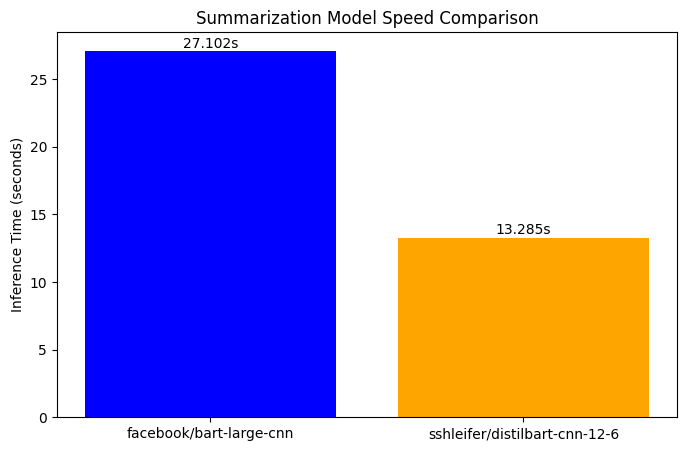

Quality comparison based on summary length and text (you can manually evaluate the summaries):
Length of facebook/bart-large-cnn summary: 365 characters
Length of sshleifer/distilbart-cnn-12-6 summary: 328 characters


In [ ]:
import time
from transformers import pipeline
import matplotlib.pyplot as plt

# Load both summarizers
summarizer_bart = pipeline("summarization", model="facebook/bart-large-cnn")
summarizer_distilbart = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

text = """BENCH: A.K. MATHUR & MARKANDEY KATJU JUDGMENT: J U D G M E N T  A.K. MATHUR, J. 1. These appeals are directed against the order dated 15th may 2003 passed by the Division Bench of Madhya Pradesh High Court in Writ Petition No. 5634 of 1999, whereby Shiv Nath Prasad, appellant (herein) challenged the order passed by the State Administrative Tribunal challenging the promotion of petitioner/appellant before us and private respondents who belong to non-scheduled caste. The case of the appellant (herein) was that he was appointed as Assistant Engineer in the Public Works Department after selection through Madhya Pradesh Public Service Commission. Petitioner/Appellant (Scheduled Caste) alongwith other Schedule Caste and other private respondents (non-SC) were selected and appointed as Assistant Engineers on the basis of Civil Services Examination conducted by the Madhya Pradesh Public Service Commission. The names of scheduled caste candidates appeared at S.Nos. 23, 24 and 25 below the name of the respondent Saran Pal Jeet Singh Tulsi (herein). After their appointment, they joined the duties on the post of Assistant Engineer on different dates in the year 1972. The names of the petitioner/appellant and other scheduled caste candidates were shown in the select list prepared by the Public Service Commission in lower position and their seniority was also drawn on the post of Assistant Engineer in the order mentioned in the select list. In the gradation list, issued for the post of Assistant Engineer as on 1.4.1982, the names of the petitioner/appellant and other scheduled caste candidates duly selected appeared at S. Nos 187, 189 and 190, while the name of the respondent no. 1 (herein) and others appeared between S.Nos 168-186. Therefore, admittedly, the respondents (herein) were senior to the petitioner/appellant. Thereafter, the petitioner/appellant was promoted to the post of the Executive Engineer in July, 1980 against the reserved post of the Executive Engineer, whereas, other private respondents (non-scheduled caste candidates) were not considered for promotion on account of non-availability of post in general category. But, they were considered and appointed on the post of Executive Engineer in the year 1985, i.e. much after the promotions of the scheduled caste candidates including that of petitioner/appellant."""

# Measure speed for facebook/bart-large-cnn
start_bart = time.time()
summary_bart = summarizer_bart(text, max_length=150, min_length=50, do_sample=False)[0]['summary_text']
end_bart = time.time()
time_bart = end_bart - start_bart

# Measure speed for sshleifer/distilbart-cnn-12-6
start_distilbart = time.time()
summary_distilbart = summarizer_distilbart(text, max_length=150, min_length=50, do_sample=False)[0]['summary_text']
end_distilbart = time.time()
time_distilbart = end_distilbart - start_distilbart

print("Summary by facebook/bart-large-cnn:\n", summary_bart)
print(f"Time taken: {time_bart:.3f} seconds\n")

print("Summary by sshleifer/distilbart-cnn-12-6:\n", summary_distilbart)
print(f"Time taken: {time_distilbart:.3f} seconds\n")

# Plotting speed comparison
models = ['facebook/bart-large-cnn', 'sshleifer/distilbart-cnn-12-6']
times = [time_bart, time_distilbart]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, times, color=['blue', 'orange'])
plt.ylabel('Inference Time (seconds)')
plt.title('Summarization Model Speed Comparison')

# Annotate bars with time values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}s", ha='center', va='bottom')

plt.show()

# Optional quality comparison:
print("Quality comparison based on summary length and text (you can manually evaluate the summaries):")
print(f"Length of facebook/bart-large-cnn summary: {len(summary_bart)} characters")
print(f"Length of sshleifer/distilbart-cnn-12-6 summary: {len(summary_distilbart)} characters")


In [ ]:
orig_len = len(text.split())
bart_len = len(summary_bart.split())
distilbart_len = len(summary_distilbart.split())

print(f"Original text length (words): {orig_len}")
print(f"facebook/bart-large-cnn summary length (words): {bart_len} ({bart_len/orig_len:.2%} of original)")
print(f"sshleifer/distilbart-cnn-12-6 summary length (words): {distilbart_len} ({distilbart_len/orig_len:.2%} of original)")


Original text length (words): 361
facebook/bart-large-cnn summary length (words): 55 (15.24% of original)
sshleifer/distilbart-cnn-12-6 summary length (words): 50 (13.85% of original)


In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode original text and summaries
emb_orig = model.encode(text, convert_to_tensor=True)
emb_bart = model.encode(summary_bart, convert_to_tensor=True)
emb_distilbart = model.encode(summary_distilbart, convert_to_tensor=True)

# Compute cosine similarity
sim_bart = util.pytorch_cos_sim(emb_orig, emb_bart).item()
sim_distilbart = util.pytorch_cos_sim(emb_orig, emb_distilbart).item()

print(f"Semantic similarity between original text and facebook/bart-large-cnn summary: {sim_bart:.3f}")
print(f"Semantic similarity between original text and sshleifer/distilbart-cnn-12-6 summary: {sim_distilbart:.3f}")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Semantic similarity between original text and facebook/bart-large-cnn summary: 0.789
Semantic similarity between original text and sshleifer/distilbart-cnn-12-6 summary: 0.796


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Device set to use cpu


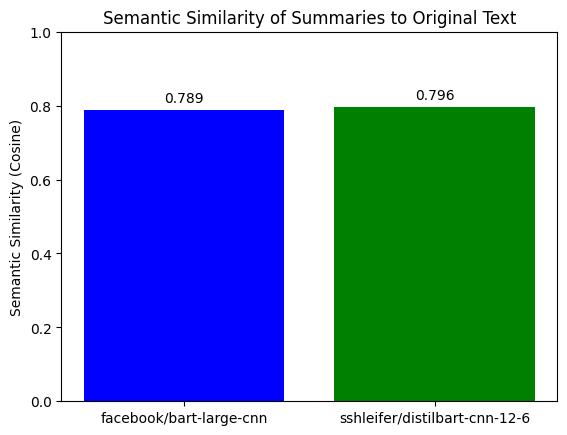

In [ ]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

# Load summarization pipelines
summarizer_bart = pipeline("summarization", model="facebook/bart-large-cnn")
summarizer_distilbart = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

text = """BENCH: A.K. MATHUR & MARKANDEY KATJU JUDGMENT: J U D G M E N T  A.K. MATHUR, J. 1. These appeals are directed against the order dated 15th may 2003 passed by the Division Bench of Madhya Pradesh High Court in Writ Petition No. 5634 of 1999, whereby Shiv Nath Prasad, appellant (herein) challenged the order passed by the State Administrative Tribunal challenging the promotion of petitioner/appellant before us and private respondents who belong to non-scheduled caste. The case of the appellant (herein) was that he was appointed as Assistant Engineer in the Public Works Department after selection through Madhya Pradesh Public Service Commission. Petitioner/Appellant (Scheduled Caste) alongwith other Schedule Caste and other private respondents (non-SC) were selected and appointed as Assistant Engineers on the basis of Civil Services Examination conducted by the Madhya Pradesh Public Service Commission. The names of scheduled caste candidates appeared at S.Nos. 23, 24 and 25 below the name of the respondent Saran Pal Jeet Singh Tulsi (herein). After their appointment, they joined the duties on the post of Assistant Engineer on different dates in the year 1972. The names of the petitioner/appellant and other scheduled caste candidates were shown in the select list prepared by the Public Service Commission in lower position and their seniority was also drawn on the post of Assistant Engineer in the order mentioned in the select list. In the gradation list, issued for the post of Assistant Engineer as on 1.4.1982, the names of the petitioner/appellant and other scheduled caste candidates duly selected appeared at S. Nos 187, 189 and 190, while the name of the respondent no. 1 (herein) and others appeared between S.Nos 168-186. Therefore, admittedly, the respondents (herein) were senior to the petitioner/appellant. Thereafter, the petitioner/appellant was promoted to the post of the Executive Engineer in July, 1980 against the reserved post of the Executive Engineer, whereas, other private respondents (non-scheduled caste candidates) were not considered for promotion on account of non-availability of post in general category. But, they were considered and appointed on the post of Executive Engineer in the year 1985, i.e. much after the promotions of the scheduled caste candidates including that of petitioner/appellant."""

# Generate summaries
summary_bart = summarizer_bart(text, max_length=150, min_length=50, do_sample=False)[0]['summary_text']
summary_distilbart = summarizer_distilbart(text, max_length=150, min_length=50, do_sample=False)[0]['summary_text']

# Load sentence transformer model for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings
emb_orig = model.encode(text, convert_to_tensor=True)
emb_bart = model.encode(summary_bart, convert_to_tensor=True)
emb_distilbart = model.encode(summary_distilbart, convert_to_tensor=True)

# Compute cosine similarities
sim_bart = util.pytorch_cos_sim(emb_orig, emb_bart).item()
sim_distilbart = util.pytorch_cos_sim(emb_orig, emb_distilbart).item()

# Plot results
models = ['facebook/bart-large-cnn', 'sshleifer/distilbart-cnn-12-6']
similarities = [sim_bart, sim_distilbart]

plt.bar(models, similarities, color=['blue', 'green'])
plt.ylabel('Semantic Similarity (Cosine)')
plt.title('Semantic Similarity of Summaries to Original Text')
plt.ylim(0, 1)
for i, v in enumerate(similarities):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
plt.show()
